In [1]:
import geopandas as gpd

shapefile = gpd.read_file("/kaggle/input/rzhd-hack/selected1.shp")
print(shapefile)

                    name                   geometry
0   Бекасово-Центральное  POINT (36.88475 55.40511)
1                 Перово  POINT (37.78648 55.75120)
2               Аэропорт  POINT (37.53315 55.80040)
3               Яничкино  POINT (37.85962 55.65347)
4                Красное  POINT (31.03734 54.68266)
..                   ...                        ...
64              Балашиха  POINT (37.94846 55.80955)
65        Льгов-Киевский  POINT (35.26924 51.63673)
66               Присады  POINT (37.81096 54.11987)
67               Ногинск  POINT (38.44357 55.85075)
68              Северная  POINT (37.61872 51.29396)

[69 rows x 2 columns]


In [2]:
import geopandas as gpd

# Load the shapefile
shapefile2 = gpd.read_file("/kaggle/input/rzhd-hack/all_routes_v2.shp")

# Assuming the columns for origin, destination, and distance are named 'origin', 'destination', and 'distance'
# Separating geometry from other columns
geometry = shapefile2.geometry
non_geometry = shapefile2.drop(columns='geometry')

# Aggregating non-geometry columns by summing the distances
aggregated_non_geometry = non_geometry.groupby(['origin', 'destinatio']).sum().reset_index()

# Aggregating geometry columns by grouping and applying unary_union
aggregated_geometry = shapefile2.groupby(['origin', 'destinatio'])['geometry'].apply(lambda x: x.unary_union).reset_index()

# Merging the aggregated non-geometry data with the aggregated geometry
aggregated_data = aggregated_non_geometry.merge(aggregated_geometry, on=['origin', 'destinatio'])

# Converting to GeoDataFrame
aggregated_data = gpd.GeoDataFrame(aggregated_data, geometry='geometry')

# Print the result
print(aggregated_data)


                    origin                     destinatio        id  oneway  \
0       Александро-Невская                         Рыбное  10256132       0   
1   Бекасово-Сортировочное                        Вековка  41833615      60   
2   Бекасово-Сортировочное          Люблино-Сортировочное  24567225      37   
3   Бекасово-Сортировочное                  Малоярославец  14502759      33   
4   Бекасово-Сортировочное  Москва-Сортировочная-Киевская  12674521      21   
..                     ...                            ...       ...     ...   
75                   Унеча                       Стародуб   7738604       0   
76                 Фрязево                        Ногинск   3851760      15   
77                 Щёлково               Лосиноостровская  11262971       0   
78       Ярославль-Главный               Лосиноостровская  26472587      84   
79       Ярославль-Главный                  Орехово-Зуево  20633738      66   

                                             revers

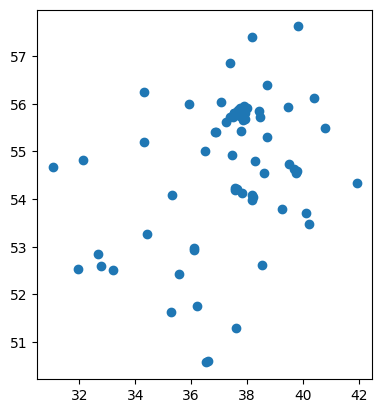

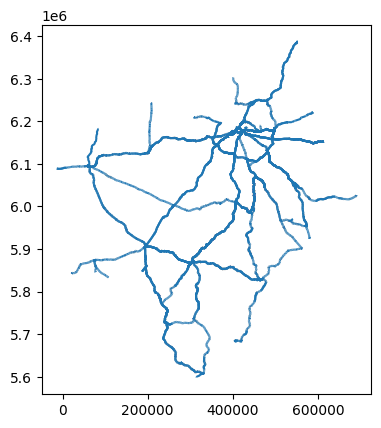

In [3]:
import matplotlib.pyplot as plt

shape2 = aggregated_data
shapefile.plot()
plt.show()

shape2.plot()
plt.show()


In [4]:
import geopandas as gpd

# Assuming your GeoDataFrame 'shapefile2' has a proper CRS set
# Calculate the length of each geometry in meters
aggregated_data['length_km'] = aggregated_data['geometry'].length / 1000

# Print the result
print(aggregated_data[['origin','destinatio','geometry', 'length_km']])

                    origin                     destinatio  \
0       Александро-Невская                         Рыбное   
1   Бекасово-Сортировочное                        Вековка   
2   Бекасово-Сортировочное          Люблино-Сортировочное   
3   Бекасово-Сортировочное                  Малоярославец   
4   Бекасово-Сортировочное  Москва-Сортировочная-Киевская   
..                     ...                            ...   
75                   Унеча                       Стародуб   
76                 Фрязево                        Ногинск   
77                 Щёлково               Лосиноостровская   
78       Ярославль-Главный               Лосиноостровская   
79       Ярославль-Главный                  Орехово-Зуево   

                                             geometry   length_km  
0   MULTILINESTRING ((580388.745 5926227.814, 5804...  207.117385  
1   MULTILINESTRING ((589802.650 6148604.962, 5897...  409.087282  
2   MULTILINESTRING ((420474.245 6171937.324, 4204...  122.1712

In [5]:
import pandas as pd

In [6]:
train_df = pd.read_csv("/kaggle/input/rzhd-hack/dataset_external.csv")
train_df

,index,value,route_start,route_end
0,1198,4.150000,Кусково,Яничкино
1,2983,14.300000,Вековка,Курск
2,3418,7.116667,Люблино-Сортировочное,Рязань-2
3,1955,20.333333,Красное,Погар
4,1697,13.900000,Белгород,Елец
...,...,...,...,...
1514,2424,10.683333,Люберцы II,Волоколамск
1515,1364,9.166667,Волоколамск,Вековка
1516,1419,10.866667,Перово,Елец
1517,1723,9.483333,Волоколамск,Узуново


In [7]:
import geopandas as gpd
import networkx as nx



In [8]:
all_routes = aggregated_data


# Create an empty graph
G = nx.Graph()

# Add nodes (stations) to the graph
stations = set(all_routes['origin']).union(set(all_routes['destinatio']))
G.add_nodes_from(stations)

# Add edges (routes) to the graph with distance as weight
for index, row in all_routes.iterrows():
    G.add_edge(row['origin'], row['destinatio'], weight=row['length_km'])
    # Assuming undirected graph, add the reverse edge
    G.add_edge(row['destinatio'], row['origin'], weight=row['length_km'])

# Optional: If you have additional attributes like route type, you can add them as edge attributes too
# for index, row in all_routes.iterrows():
#     G[row['origin']][row['destination']]['route_type'] = row['route_type']


In [9]:
# Function to find shortest path between start and end stations
def find_shortest_path(start_station, end_station):
    try:
        if not(start_station in G and end_station in G):
            return 0,0,0
        else:
            shortest_path = nx.shortest_path(G, start_station, end_station, weight='weight')
            shortest_distance = nx.shortest_path_length(G, start_station, end_station, weight='weight')
            num_stations = len(shortest_path) - 1
            return shortest_path, shortest_distance, num_stations
    except nx.NetworkXNoPath:
        return None, float('inf'), float('inf')  # No path found

# Example: Iterate over train_df to find optimal paths
for index, row in train_df.iterrows():
    start_station = row['route_start']
    end_station = row['route_end']
    
    shortest_path, shortest_distance, num_stations = find_shortest_path(start_station, end_station)
    
    if shortest_path:
        # Update train_df with optimal distance
        train_df.at[index, 'optimal_distance_km'] = shortest_distance
        train_df.at[index, 'num_stations'] = num_stations
    else:
        train_df.at[index, 'optimal_distance_km'] = 0  # or any default value for no path found
        train_df.at[index, 'num_stations'] = 0

# Print updated train_df
print(train_df)



      index      value            route_start    route_end  \
0      1198   4.150000                Кусково     Яничкино   
1      2983  14.300000                Вековка        Курск   
2      3418   7.116667  Люблино-Сортировочное     Рязань-2   
3      1955  20.333333                Красное        Погар   
4      1697  13.900000               Белгород         Елец   
...     ...        ...                    ...          ...   
1514   2424  10.683333             Люберцы II  Волоколамск   
1515   1364   9.166667            Волоколамск      Вековка   
1516   1419  10.866667                 Перово         Елец   
1517   1723   9.483333            Волоколамск      Узуново   
1518   1006   6.466667               Рязань-2       Перово   

      optimal_distance_km  num_stations  
0              268.887101           2.0  
1             1166.548994           5.0  
2              314.678247           2.0  
3             2668.333561           7.0  
4              822.466978           4.0  
...

In [10]:
test_df = pd.read_csv("/kaggle/input/rzhd-hack/dataset_internal.csv")

In [11]:
# Function to find shortest path between start and end stations
def find_shortest_path(start_station, end_station):
    try:
        if not(start_station in G and end_station in G):
            return 0,0,0
        else:
            shortest_path = nx.shortest_path(G, start_station, end_station, weight='weight')
            shortest_distance = nx.shortest_path_length(G, start_station, end_station, weight='weight')
            num_stations = len(shortest_path) - 1
            return shortest_path, shortest_distance, num_stations
    except nx.NetworkXNoPath:
        return None, float('inf'), float('inf')  # No path found

# Example: Iterate over train_df to find optimal paths
for index, row in test_df.iterrows():
    start_station = row['route_start']
    end_station = row['route_end']
    
    shortest_path, shortest_distance, num_stations = find_shortest_path(start_station, end_station)
    
    if shortest_path:
        # Update train_df with optimal distance
        test_df.at[index, 'optimal_distance_km'] = shortest_distance
        test_df.at[index, 'num_stations'] = num_stations
    else:
        test_df.at[index, 'optimal_distance_km'] = 0  # or any default value for no path found
        test_df.at[index, 'num_stations'] = 0

# Print updated train_df
print(test_df)



      index                 route_start               route_end  \
0      2623                      Вязьма                 Щёлково   
1      4413                    Аэропорт                   Лесок   
2       480                     Узуново           Малоярославец   
3      4409                    Серпухов                   Лесок   
4      9286                  Кунцево II                 Петушки   
...     ...                         ...                     ...   
1514   1676                        Елец                  Перово   
1515   8047                 Зелёный Бор                 Вековка   
1516     37  Москва-Товарная-Смоленская            Курбакинская   
1517   1179      Смоленск-Сортировочный                Владимир   
1518   8020                    Аэропорт  Бекасово-Сортировочное   

      optimal_distance_km  num_stations  
0              757.835709           4.0  
1                0.000000           0.0  
2              438.417927           4.0  
3              433.693874  

In [12]:
from sklearn.preprocessing import LabelEncoder

# Example data
data_train1 = train_df["route_start"]
data_train2 = train_df["route_end"]

encoder1 = LabelEncoder()
encoder2 = LabelEncoder()
encoded_data1 = encoder1.fit_transform(data_train1)
encoded_data2 = encoder2.fit_transform(data_train2)


print(encoded_data1)
print(encoded_data2)



[19  7 25 ... 34  9 42]
[55 18 42 ... 12 52 34]


In [13]:
# Example data
data_test1 = test_df["route_start"]
data_test2 = test_df["route_end"]
encoded_test_data1 = encoder1.transform(data_test1)
encoded_test_data2 = encoder2.transform(data_test2)


print(encoded_test_data1)
print(encoded_test_data2)

[11  2 52 ... 28 46  2]
[54 20 26 ... 17  8  4]


In [14]:
train_df["route_start"] = encoded_data1
train_df["route_end"] = encoded_data2
test_df["route_start"] = encoded_test_data1
test_df["route_end"] = encoded_test_data1

In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor, Pool, cv

# Assuming 'optimal_distance_km' is the target variable
X = train_df.drop(columns=['value'])  # Features
y = train_df['value']  # Target variable

# Split data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [16]:
# Define CatBoost parameters
catboost_params = {
    'iterations': 1000,
    'learning_rate': 0.1,
    'depth': 10,
    'loss_function': 'RMSE',
    'random_seed': 42
}

# Convert data to CatBoost Pool format
train_pool = Pool(data=X_train, label=y_train)
val_pool = Pool(data=X_val, label=y_val)

# Perform cross-validation
cv_results = cv(pool=train_pool,
                params=catboost_params,
                fold_count=5,  # Number of folds for cross-validation
                verbose=100,  # Print progress every 100 iterations
                plot=True)  # Plot training metrics

# Get best iteration
best_iteration = len(cv_results)  # Use the number of iterations where the best metric was achieved

print(f"Best RMSE: {cv_results['test-RMSE-mean'].min():.2f} ± {cv_results['test-RMSE-std'].mean():.2f} at iteration {best_iteration}")


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]
0:	learn: 11.1297104	test: 11.2343777	best: 11.2343777 (0)	total: 80.1ms	remaining: 1m 20s
100:	learn: 1.6830230	test: 2.5126504	best: 2.5126504 (100)	total: 662ms	remaining: 5.89s
200:	learn: 1.0428637	test: 2.4083243	best: 2.4081930 (198)	total: 1.25s	remaining: 4.96s
300:	learn: 0.7048156	test: 2.3858909	best: 2.3813383 (294)	total: 1.88s	remaining: 4.36s
400:	learn: 0.5006747	test: 2.3863016	best: 2.3813383 (294)	total: 2.66s	remaining: 3.97s
500:	learn: 0.3500980	test: 2.3834995	best: 2.3813383 (294)	total: 3.33s	remaining: 3.32s
600:	learn: 0.2590433	test: 2.3874424	best: 2.3813383 (294)	total: 3.94s	remaining: 2.61s
700:	learn: 0.1975998	test: 2.3868662	best: 2.3813383 (294)	total: 4.49s	remaining: 1.91s
800:	learn: 0.1502182	test: 2.3863840	best: 2.3813383 (294)	total: 5.07s	remaining: 1.26s
900:	learn: 0.1150003	test: 2.3876252	best: 2.3813383 (294)	total: 5.63s	remaining: 619ms
999:	learn: 0.0874159	test: 2.3884803	best: 2.3813383 (294)	total: 6.22s	rem

In [17]:
# Initialize CatBoostRegressor with best parameters
best_model = CatBoostRegressor(iterations=best_iteration,
                               learning_rate=0.1,
                               depth=10,
                               loss_function='RMSE',
                               random_seed=42)

# Fit model on entire training data
best_model.fit(X, y, verbose=100)  # Verbose to see progress every 100 iterations

0:	learn: 4.3875293	total: 8.28ms	remaining: 8.28s
100:	learn: 1.7682440	total: 634ms	remaining: 5.64s
200:	learn: 1.2284462	total: 1.21s	remaining: 4.82s
300:	learn: 0.9005168	total: 1.9s	remaining: 4.41s
400:	learn: 0.6837076	total: 2.62s	remaining: 3.91s
500:	learn: 0.5343551	total: 3.27s	remaining: 3.25s
600:	learn: 0.4204880	total: 3.87s	remaining: 2.57s
700:	learn: 0.3349544	total: 4.46s	remaining: 1.9s
800:	learn: 0.2697275	total: 5.04s	remaining: 1.25s
900:	learn: 0.2187055	total: 5.64s	remaining: 619ms
999:	learn: 0.1747739	total: 6.24s	remaining: 0us


In [18]:
# Predict on test data
y_pred = best_model.predict(X_val)

from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate RMSE and MAE
rmse = mean_squared_error(y_val, y_pred, squared=False)
mae = mean_absolute_error(y_val, y_pred)

print(f"RMSE: {rmse:.2f} hours")
print(f"MAE: {mae:.2f} hours")


RMSE: 0.17 hours
MAE: 0.13 hours


In [19]:
# Assuming 'test_df' has similar structure as 'train_df' without 'optimal_distance_km'
test_pred = best_model.predict(test_df)

# Print or use 'test_pred' as needed for your application
print(test_pred)

[11.47556903 16.53952998  7.63443565 ... 12.30177298 10.54884825
 19.8562104 ]


In [20]:
test_df

,index,route_start,route_end,optimal_distance_km,num_stations
0,2623,11,11,757.835709,4.0
1,4413,2,2,0.000000,0.0
2,480,52,52,438.417927,4.0
3,4409,45,45,433.693874,3.0
4,9286,16,16,716.954299,5.0
...,...,...,...,...,...
1514,1676,12,12,0.000000,0.0
1515,8047,13,13,454.405937,3.0
1516,37,28,28,703.990153,4.0
1517,1179,46,46,941.980834,4.0


In [21]:
train_df

,index,value,route_start,route_end,optimal_distance_km,num_stations
0,1198,4.150000,19,55,268.887101,2.0
1,2983,14.300000,7,18,1166.548994,5.0
2,3418,7.116667,25,42,314.678247,2.0
3,1955,20.333333,15,37,2668.333561,7.0
4,1697,13.900000,5,12,822.466978,4.0
...,...,...,...,...,...,...
1514,2424,10.683333,24,9,0.000000,0.0
1515,1364,9.166667,9,7,639.926471,2.0
1516,1419,10.866667,34,12,0.000000,0.0
1517,1723,9.483333,9,52,589.934647,4.0


In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


2024-07-03 12:17:40.980705: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-03 12:17:40.980857: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-03 12:17:41.157044: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [23]:
train_df.dropna()

,index,value,route_start,route_end,optimal_distance_km,num_stations
0,1198,4.150000,19,55,268.887101,2.0
1,2983,14.300000,7,18,1166.548994,5.0
2,3418,7.116667,25,42,314.678247,2.0
3,1955,20.333333,15,37,2668.333561,7.0
4,1697,13.900000,5,12,822.466978,4.0
...,...,...,...,...,...,...
1514,2424,10.683333,24,9,0.000000,0.0
1515,1364,9.166667,9,7,639.926471,2.0
1516,1419,10.866667,34,12,0.000000,0.0
1517,1723,9.483333,9,52,589.934647,4.0


In [24]:
# Assuming 'optimal_distance_km' is the target variable
X = train_df.drop(columns=["index",'value'])  # Features
y = train_df['value']  # Target variable

# Split data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:

# Scale the data (optional but recommended for neural networks)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_val)



In [26]:
X_test_scaled

array([[ 1.21757331,  1.51603742,  2.16620932,  2.19019234],
       [ 1.21757331,  0.31003653,  0.21429895,  0.71536303],
       [-1.63515405,  0.79243688, -0.13068899,  0.22375325],
       ...,
       [-1.57445772,  1.57633746, -1.4144132 , -1.74268583],
       [-1.39236874, -1.43866477,  0.32782355,  0.71536303],
       [ 0.42852106, -1.0768645 , -0.65309174, -0.26785652]])

In [27]:

# Build the neural network
model = Sequential([
    Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)  # No activation function for regression
])

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate on test data
mse = model.evaluate(X_test_scaled, y_val)
print(f"Mean Squared Error on test data: {mse}")

# Make predictions
predictions = model.predict(X_test_scaled)
print("Predictions:")
print(predictions)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 135.2433 - val_loss: 121.4114
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 103.7808 - val_loss: 66.7498
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 45.9636 - val_loss: 20.0622
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 15.2414 - val_loss: 15.0155
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 13.2469 - val_loss: 14.0438
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 12.6832 - val_loss: 13.4635
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 11.6419 - val_loss: 13.0635
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 12.6617 - val_loss: 12.7082
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 11.6533 - val_loss: 12.4818
Epoch 10/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 11.0894 - val_loss: 12.2394
Epoch 11/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 11.5768 - val_loss: 12.0402
Epoch 12/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1

In [28]:
test_df = test_df.drop(columns = ["index"])

In [29]:
test = scaler.transform(test_df)
test

array([[-1.02819078, -1.01656445, -0.05490136,  0.22375325],
       [-1.57445772, -1.55926486, -1.4144132 , -1.74268583],
       [ 1.46035862,  1.45573737, -0.62791772,  0.22375325],
       ...,
       [ 0.00364678,  0.0085363 , -0.15149706,  0.22375325],
       [ 1.09618066,  1.0939371 ,  0.27544395,  0.22375325],
       [-1.57445772, -1.55926486, -1.4144132 , -1.74268583]])

In [30]:
predictions = model.predict(test)
print("Predictions:")
print(predictions)

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Predictions:
[[11.681753]
 [12.163107]
 [10.074687]
 ...
 [10.767484]
 [11.349329]
 [12.163107]]


In [31]:
train = train_df.drop(columns=["index", "value"])

In [32]:
train = scaler.transform(train)
train

array([[-0.54262017,  1.63663751, -0.93204586, -0.75946629],
       [-1.27097609, -0.59446414,  0.67830577,  0.71536303],
       [-0.17844221,  0.85273693, -0.84989929, -0.75946629],
       ...,
       [ 0.36782474, -0.95626441, -1.4144132 , -1.74268583],
       [-1.14958343,  1.45573737, -0.35610581,  0.22375325],
       [ 0.85339535,  0.37033657, -1.4144132 , -1.74268583]])

In [33]:
predictions = model.predict(train)
print("Predictions:")
print(predictions[:10])

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Predictions:
[[ 6.641239]
 [13.980566]
 [ 6.907163]
 [19.677187]
 [12.222637]
 [11.853641]
 [ 9.715377]
 [12.080406]
 [11.056427]
 [ 9.244298]]


In [34]:
predictions, test_pred

(array([[ 6.641239],
        [13.980566],
        [ 6.907163],
        ...,
        [10.835276],
        [11.111803],
        [ 9.969092]], dtype=float32),
 array([11.47556903, 16.53952998,  7.63443565, ..., 12.30177298,
        10.54884825, 19.8562104 ]))

In [35]:
test_csv = pd.read_csv("/kaggle/input/rzhd-hack/dataset_internal.csv")
test_csv

,index,route_start,route_end
0,2623,Вязьма,Щёлково
1,4413,Аэропорт,Лесок
2,480,Узуново,Малоярославец
3,4409,Серпухов,Лесок
4,9286,Кунцево II,Петушки
...,...,...,...
1514,1676,Елец,Перово
1515,8047,Зелёный Бор,Вековка
1516,37,Москва-Товарная-Смоленская,Курбакинская
1517,1179,Смоленск-Сортировочный,Владимир


In [36]:
test_csv["value_predict"] = predictions

In [37]:
test_csv.to_csv("dense_predict.csv")

In [38]:
test_csv["value_predict"] = test_pred

In [39]:
test_csv.to_csv("cb_predict.csv")